# 8장 차원 축소
## 주요 내용
- 차원의 저주
- 차원축소를 위한 접근법
  - 사영 기법
  - 다양체 학습
- 사영 기법 알고리즘
  - PCA(주성분 분석)
  - 커널 PCA
- 다양체 학습 알고리즘
  - LLE(지역 선형 임베딩)

## 기본 설정

In [1]:
# 파이썬 ≥3.5 필수 (파이썬 3.7 추천)
import sys
assert sys.version_info >= (3, 5) 

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림 저장 위치 지정
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 차원의 저주
### 고차원 공간의 특징
- 3차원(3D)을 초고하는 고차원 공간의 구조를 상상하기는 매우 어려움.
- 고차원 공간의 경우 두 지점 사이의 거리가 매우 멀어질 수 있으며 이는 특성 수가 많은 데이터들 사이의 거리가 매우 멀어질 수 있음을 의미함.

### 차원의 저주
- 머신러닝에서 다루는 많은 문제가 수 천에서 수 백만의 특성을 가진 데이터를 다룸. 이는 데이터셋의 특성이 이루는 공간이 수 천에서 수 백만 차원의 공간임을 의미함.
- 수 천에서 수 백만의 차원을 갖는 데이터셋을 훈련시키는 데에 엄청난 시간과 비용이 발생함.
- 또한 데이터 사이가 멀기 때문에 새로운 데이터에 대한 예측값을 계산하기 위해 많은 추정 과정을 밟아야 하며, 따라서 과대적합 위험도가 커지는 등 훈련이 매우 어려워짐.
- 데이터 사이의 거리를 충분히 작게 만들기 위해 천문학적 크기의 데이터셋이 요구되기에 사실상 해결 불가능한 문제임.

### 차원 축소
- 많은 실전 문제의 데이터셋의 특성들이 이루는 차원을 혁신적으로 줄일 수 있음.
- 차원축소: 고차원의 데이터셋을 저차원의 데이터셋으로 변환하는 과정
- 예제: MNIST 데이터셋의 경우 손글씨 이미지의 테두리 영역은 거의 항상 흰색이기에 숫자 인식을 위해 아무런 역할을 하지 않음. 따라서 그 영역을 제외한 특성들의 차원만을 이용할 수 있음. 실제로 784(= 18 * 18)개의 픽셀 특성 대신에 154개의 픽셀 특성만을 사용해도 숫자 분류를 진행할 수 있음을 아래에서 확일할 것임.

#### 장점과 단점
- 차원축소를 진행하면 정보를 일부 또는 상당히 잃게 됨. 따라서 적절한 수의 차원으로 축소를 진행해야 하며 어느 정도로 줄이는 것이 적절한지 먼저 알아내야 함.
- 반면에 차원축소 후 훈련 속도가 보다 많이 빨라짐.
- 또한 2, 3차원으로 줄일 경우 데이터 시각화가 가능해져서 데이터들의 패턴을 인식 가능해질 수 있음.



## 차원축소 기법 소개
### 사영 기법
특잇값 분해를 이용한 사영 기법을 설명하기 위해 3차원 공간에 분포된 60개의 점을 2차원으로 사영하는 예제를 이용한다.

In [2]:
np.random.seed(4)

m = 60
noise = 0.1

X = np.empty((m, 3))

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2   # x 좌표
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2                # y 좌표

w1, w2 = 0.1, 0.3
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)             # z 좌표 (초평면 + 잡음)

### PCA(주성분 분석)
데이터셋의 주성분은 데이터 샘플들의 분산을 최대로 유지하는 축을 가리키며 차원의 개수만큼 주성분이 존재한다. 분산을 최대로 유지하는 축이 첫째 주성분이며, 이후의 축은 이전 축에 수직이면서 동시에 남은 분산을 최대한 보존하는 축으로 지정한다. 이 과정을 차원 수 만큼의 주성분을 찾을 때까지 반복한다.

#### 차원축소
차원축소는 PCA를 통해 찾은 주성분의 일부로 구성된 초평면(하이퍼플레인 Hyperplane)으로 데이터 샘플들을 사영(Projection)하는 과정을 의미한다.

첫째부터 d 번째까지의 주성분을 축으로 사용해서 생성되는 d 차원의 공간으로 데이터셋이 사영된다. 

### 특잇값 분해(SVD)
데이터셋의 분산에 대한 주성분은 데이터셋 행렬의 특잇값 분해(SVD, singular value decomposition)를 이용하여 쉽게 구할 수 있다. 사이킷런의 `PCA` 모델이 특잇값 분해를 이용하여 주성분을 바로 계산할 수 있지만 여기서는 먼저 특잇값 분해를 사용하여 직접 주성분을 구하는 과정을 살펴본다.

**주의사항**: 평균값(mean)이 이라는 가정하에 특잇값 분해를 진행해야 하기에 아래 코드를 먼저 실행한다.

In [3]:
X_centered = X - X.mean(axis=0)

특잇값 분해의 내용은 다음과 같다.
평균값이 0인 데이터셋 가 주어졌을 때 아래 조건을 만족시키는 세 개의 행렬 U, E, V가 존재한다.
X = UEV^T

- X: m x n 행렬
- U: m x m 행렬
- E: m x n 모양의 대각행렬(diagonal matrix).
- V: n x n 행렬. 윗첨자 는 전치행렬을 의미함.
특잇값 분해를 진행하는 `numpy.linalg.svd()` 함수를 이용하여 `X_centered`에 대해 특잇값 분해를 진행한 결과는 다음과 같다.
- `s`:대각행렬 E에 해당하지만 대각선상에 위치한 값들만 모아 놓은 길이 3인 1차원 어레이임.
- 'V^T`:즉, 행렬 V의 전치행렬에 해당함.

In [4]:
U, s, Vt = np.linalg.svd(X_centered)

각 행렬의 모양을 확인하면 다음과 같다.

In [5]:
U.shape

(60, 60)

앞서 언급한 대로 s는 원래 (60, 3) 모양의 대각 행렬 이어야 하지만 여기서는 대각선 상에 위치한 세 개의 수만 포함하고 있다.

**참고**: (60, 3) 모양의 대각선은 길이가 3이다.

In [6]:
s.shape

(3,)

In [7]:
Vt.shape

(3, 3)

특잇값 분해가 제대로 이루어진 것인지 아래와 같이 검증할 수 있다.

주의사항: 행렬의 곱셈을 진행하려면 먼저 `s`를 (60, 3) 모양의 대각 행렬로 만들어야 한다.

In [8]:
S = np.zeros(X_centered.shape)
S[:3, :3] = np.diag(s)

이제 아래와 같이 특잇값 분해가 제대로 이루어졌음을 확인할 수 있다.

참고: 컴퓨터를 이용한 부동소수점 연산은 일반적으로 100% 정확하지 않다. 따라서 약간의 오차를 감안하여 두 부동소수점 값을 비교해야 한다. `numpy.allclose()` 함수는 지정된 오차범위 안에서 두 부동소수점의 일치여부를 판단한다.

In [9]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

### 2차원으로 사영하기
3차원(3D) 공간의 데이터를 2차원(2D)으로 보내려면 앞서 보여준 두 개의 주성분(principal components)을 선택한 후에 두 축에 의해 생성되는 초평면hyperplane에 사영해야 한다. 2차원으로 사영하려면 따라서 행렬 의 0번과 1번 두 개의 열을 선택한 후에 X_centered를 두 개의 주성분으로 구성된 행렬과 곱한다.

In [10]:
W2 = Vt.T[:, :2]           # 주성분 2개 선택

X2D = X_centered.dot(W2)   # 데이터셋을 2차원으로 사영

In [11]:
X2D_using_svd = X2D

### 사이킷런의 PCA 모델 활용
앞서 특잇값 분해를 직접 활용하여 2차원으로 사영하는 과정을 사이킷런의 PCA 모델을 이용하여 간단하게 해결할 수 있다.

참고: 평균값을 0으로 맞추는 것도 PCA 모델이 알아서 처리한다.

- `fit()`: 평균값을 0으로 맞춘 후 특잇값 분해를 이용하여 주성분을 찾는다.
- `transform()`: 찾은 주성분 2개를 이용하여 2차원 공간으로 데이터셋을 사영하는 과정은 다음과 같다.
  - 평균값을 0으로 맞춘다.
  - 특잇값 분해로 찾은 주성분을 이용하여 2차원으로 사영한다.

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)   # 2차원으로 사영하는 모델
X2D = pca.fit_transform(X)

**참고**: 사영된 데이터의 축별 평균은 거의 0이다.

In [13]:
X2D.mean(0)

array([3.70074342e-17, 1.38777878e-17])

**주의사항**: 사이킷런을 이용하여 PCA를 진행할 때 주성분 축이 반대 방향으로 지정되는 경우가 발생할 수 있으며 여기서도 그런 일이 벌어졌음을 아래 코드가 알려준다.

In [14]:
np.allclose(X2D, X2D_using_svd)

False

In [15]:
np.allclose(X2D, - X2D_using_svd)

True

실제로 훈련된 `PCA`가 알고 있는 주성분과 앞서 특잇값 분해로 얻은 주성분이 서로 반대방향을 가리키고 있다.

In [16]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [17]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [18]:
np.allclose(pca.components_, - Vt[:2])

True

### 재구성 오차
아래 코드는 2차원으로 사영된 데이터를 다시 3차원으로 복원한다.

In [19]:
X3D_inv = pca.inverse_transform(X2D)

그런데 2차원 공간으로 사영되면서 정보손실이 있었기에 3차원으로 복원한 값과 원래의 3차원 값 사이에 오차가 존재한다.

In [20]:
np.allclose(X3D_inv, X)

False

재구성 오차(reconstruction error)는 사영 전과 사영 후 원래 공간으로 복원한 데이터 사이의 평균제곱오차로 계산한다.

In [21]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

**참고**: `inverse_transform()` 메서드가 내부에서는 사영할 때 사용된 행렬의 전치행렬을 사영된 데이터셋에 곱한다.

In [22]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

앞서 구한 `inverse_transform()` 메서드의 결과와 비교하기 위해선 다시 데이터셋의 평균값을 빼주어야 한다.

In [23]:
X.mean(0)

array([0.02406745, 0.20932515, 0.07155422])

그런데 `PCA` 모델의 `mean_ `속성에 동일한 값이 저장되어 있다.

In [24]:
pca.mean_

array([0.02406745, 0.20932515, 0.07155422])

이제 두 값을 비교하면 다음과 같이 일치한다.

In [25]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

### 설명 분산 비율
설명 분산 비율은 각 주성분의 축에 대한 데이텃셈의 분산 비율을 의미한다. PCA 객체의 explained_variance_ratio_ 속성에 사영에 사용된 주성분별 설명 분산 비율이 저장되어 있다.

- 첫째 주성분의 축에 대한 데이터셋의 분산 비율:84.25%
- 둘째 주성분의 축에 대한 데이터셋의 분산 비율:14.63%

In [26]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

즉, 2차원으로 사영한 결과 1.1% 정도의 분산을 잃는다.

In [27]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

**참고**: 특잇값 분해로 생성된 행렬 `s`를 이용하여 모든 주성분에 대한 설명 분산 비율을 계산할 수 있다.

In [28]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

#### 사영 그래프 코드
지금까지 사용된 그래프를 그리는 코드는 다음과 같다.

- 3차원 화살표 그리기 함수

In [29]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

- 3차원 공간에서의 2차원 초평면 좌표

In [30]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)                      # x축, y축 좌표

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])   # z축 좌표

- 그래프 그리기: 3D 데이터셋, 평면, 그리고 사영 과정

Saving figure dataset_3d_plot


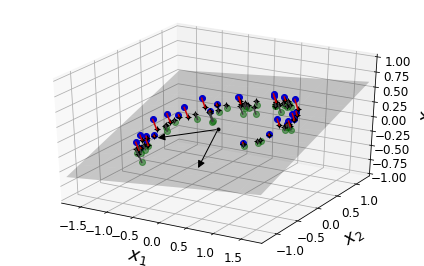

In [31]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

# 3차원 데이터 산점도 그리기: 초평면 윗쪽, 아랫쪽 데이터 구분
X3D_above = X[X[:, 2] > X3D_inv[:, 2]]    # 초평면 윗쪽 데이터
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]   # 초평면 아랫쪽 데이터

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "go", alpha=0.5)

# 주성분의 축 그리기
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

# 초평면 그리기
ax.plot_surface(x1, x2, z, alpha=0.2, color="k")

# 초평면으로 사영된 데이터셋 그리기
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")

# 사영 과정
for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "r-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "r-", color="#505050")

# 축 레이블 표기
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

save_fig("dataset_3d_plot")
plt.show()

- 2차원 공간으로 사영된 데이터셋 그리기

Saving figure dataset_2d_plot


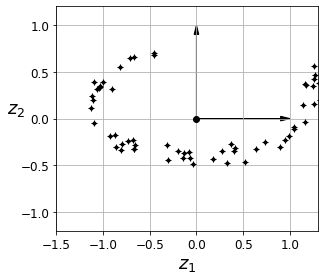

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

### 사영기법의 한계
사영기법이 차원축소의 최선이 아닌 경우가 존재한다. 이어서 설명하는 롤케이크의 경우처럼 데이터셋을 구성하는 저차원 공간이 꼬이거나 뒤집혀 있는 경우 사영기법을 적용하면 오히려 문제를 보다 어렵게 만들 수 있다.

### 롤케이크(스위스 롤) 그리기
아래 코드는 롤케이크(swill roll) 데이터셋을 생성한다.

- X: 롤케이크 데이터셋(3차원)
- t: 롤케이크 생성에 사용되는 1차원 데이터셋.
  - 참고: `make_swiss_roll()`

In [33]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Saving figure swiss_roll_plot


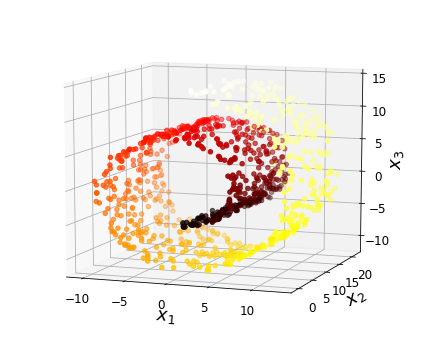

In [34]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

# 롤케이크 데이터셋 산점도
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)   # t에 의존한 색상 지정

ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

### 롤케이크 사영하기와 펼치기
롤케이크 모양의 데이터셋을 2차원으로 사영(아래 그림 왼편)해도 분류를 깨끗하게 실행할 수 없다.

- 사영: $x_1$과 $x_2$를 주성분 축으로 사용함. 즉 $x_3$를 무시함.

Saving figure squished_swiss_roll_plot


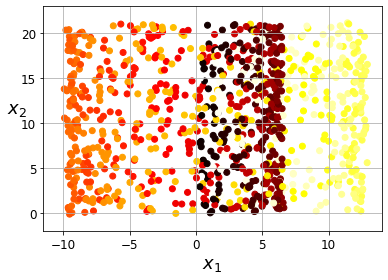

In [35]:
fig = plt.figure(figsize=(5.5, 4))

# 왼편 그림: 사영
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
ax.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

반면에 아래 그림 오른편처럼 돌돌 말린 데이터셋을 평평하게 펼치면 보다 쉽게 분류가 가능해진다.

Saving figure unrolled_swiss_roll_plot


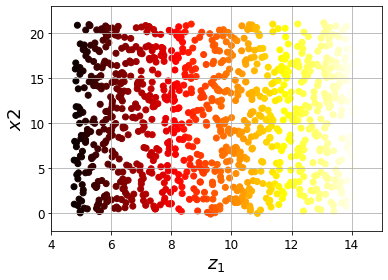

In [36]:
fig = plt.figure(figsize=(5.5, 4))

# 오른편 그림: 펼치기
ax = fig.add_subplot(111)
ax.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
ax.axis([4, 15, axes[2], axes[3]])
plt.ylabel("$x2$", fontsize=18)
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("unrolled_swiss_roll_plot")
plt.show()

## 다양체 학습
### 다양체(manifold)
롤케이크는 3차원 공간에 존재한다. 반면에 위 그림에서 보듯 롤케이크를 구성하는 데이터셋 자체는 2차원 평면을 구부린 형태를 갖는다. 이처럼 저차원 공간이 구부리고 꼬인 형태로 보다 고차원의 공간에 위치하면 그런 저차원 공간을 다양체(manifold, 매니폴드)라 부른다. 예를 들어 롤케이크는 2차원 다양체가 된다.

### 다양체 학습(manifold learning)
고차원 공간에 존재하는 데이터셋의 다양체 성질을 학습하는 것의 의미한다.

#### 다양체 가정
"고차원의 데이터셋이 대부분 저차원의 다양체와 비슷한 형태를 갖는다"라는 가정을 다양체 가정 또는 다양체 가설이라 부른다.

다양체 가정과 더불어 저차원의 다양체로 표현할 경우 문제가 보다 쉬어질 것이다라는 가정도 함께 많이 사용된다. 앞서 살펴본 롤케이크의 경우가 이 가정을 만족시킨다. 하지만 이 가정또한 항상 성립하지는 않음을 아래 그래프가 잘 보여준다.

- 위쪽 그림: 3차원 롤케이크 모양의 데이터셋
- 아랫쪽 그림: 돌돌 말린 모양을 펼친 형태의 2차원 데이터셋

Saving figure manifold_decision_boundary_plot1


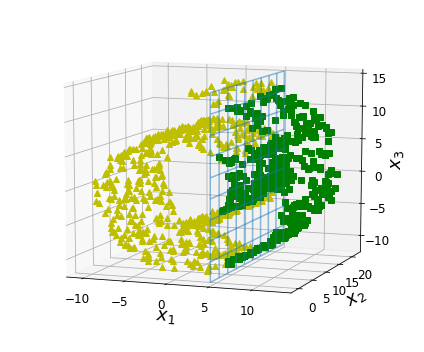

Saving figure manifold_decision_boundary_plot2


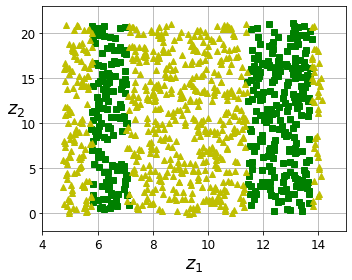

In [37]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot2")
plt.show()

반면에 아래의 경우는 저차원 다양체로 말린 부분을 펼치면 분류 문제가 매우 단순해짐을 잘 보여준다.

Saving figure manifold_decision_boundary_plot3


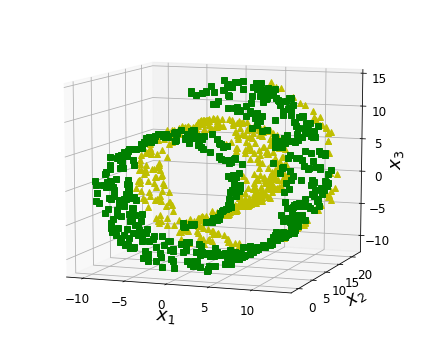

Saving figure manifold_decision_boundary_plot4


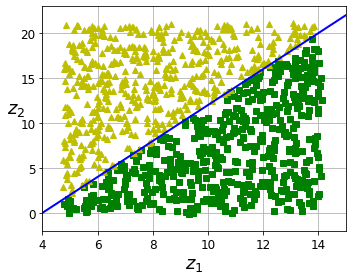

In [38]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot4")
plt.show()

## PCA
주성분 분석(PCA, principal component analysis)은 가장 많이 사용되는 차원축소 알고리즘이다. 주성분 분석의 핵심은 훈련 데이터셋의 분산을 최대한 보존하는 방향으로 차원축소를 진행하는 것이다.
### 분산 보존
아래 그림은 분산을 최대로 보존하는 주성분의 의미를 잘 보여준다.

- $c_1$: 첫째 주성분. 이 축으로 사영할 경우 분산이 가장 많이 보존됨.
- $c_2$: 둘째 주성분. 과 수직을 이루면서 분산을 가장 만히 보존하는 축.

참고: 2차원 데이터셋이므로 두 개의 주성분만 존재하며, 첫째 주성분이 정해지면 둘째 주성분은 자동으로 정해진다.

Saving figure pca_best_projection_plot


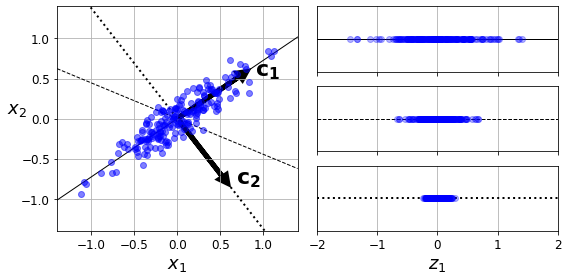

In [39]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

# 왼편 그래프
plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

# 오른편 상단 그래프: C1 축으로 사영한 데이터 그래프
plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

# 오른편 중간 그래프: C1과 C2 사이에 있는 파선으로 된 축으로 사영한 데이터 그래프
plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

# 오른편 하단 그래프: C2 축으로 사영한 데이터 그래프
plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("pca_best_projection_plot")
plt.show()

## PCA 활용: MNIST 데이터 압축
### MNIST 데이터셋 구하기
MNIST 데이터셋을 대상으로 차원축소를 진행하기 위해 먼저 MNIST 데이터셋을 불러온다.

`fetch_openml()` 함수는 지정된 데이터셋과 관련된 다양한 정보를 담은 사전(Bunch 객체) 객체를 반환하며, 특성과 타깃 데이터셋은 각각 다음 키(key)의 값으로 지정되어 있다.

- 'data' 키: 특성 데이터셋
- 'target' 키: 타깃 데이터셋
**주의 사항**: 특성 데이터셋과 타깃 데이터셋이 판다스의 DataFrame 또는 Series 객체로 저장된다. 여기서는 각 데이터셋을 넘파이 어레이로 얻기 위해 `as_frame=False` 옵션을 지정한다.

In [40]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [41]:
type(mnist)

sklearn.utils.Bunch

아래 코드는 특성 데이터셋과 타깃 데이터셋 넘파이 어레이로 지정한다.

In [42]:
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

훈련 세트와 테스트 세트로 구분한다.

- 훈련 세트: 전체 데이터셋의 75%. 52,500개의 샘플.
- 테스트 세트: 나머지.

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

#### 설명 분산 비율과 차원 축소
차원축소를 위한 적절한 차원을 확인하기 위해 설명 분산 비율이 95%가 되는 지점까지 몇 개의 주성분이 필요한가를 계산한다. MNIST 데이터셋의 경우 설명 분산 비율이 95%가 되도록 하려면 154개의 주성분이 필요함이 아래와 같이 확인된다.

In [44]:
pca = PCA()
pca.fit(X_train)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

MNIST 데이터셋과 관련된 설명 분산 비율과 차원과의 관계를 그래프로 그리면 다음과 같다.

- (154, 95) 좌표의 지점 표시
- 엘보우(Elbow): 설명 분산 비율 그래프의 증가도가 급격하게 떨어지는 지점

Saving figure explained_variance_plot


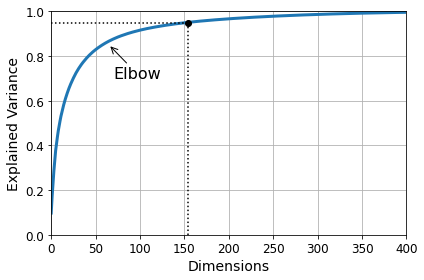

In [45]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)                                # 설명 분산 비율 그래프(파랑색 곡선)

plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")

plt.plot(d, 0.95, "ko")                                     # (154, 95) 좌표의 점
plt.plot([d, d], [0, 0.95], "k:")                           # 수직 점선
plt.plot([0, d], [0.95, 0.95], "k:")                        # 수평 점선
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),      # Elbow 주석
             arrowprops=dict(arrowstyle="->"), fontsize=16)

plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

차원을 직접 지정하는 대신 `n_components` 옵션에 설명 분산 비율을 지정하면 자동으로 해당 분산 비율을 만족하는 최소 차원으로 데이터셋을 사영할 수 있다.

In [46]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

몇 개의 주성분이 사용되었는가는 `n_components_` 속성이 알고 있다.

In [47]:
pca.n_components_

154

#### 재구성 오차
재구성 오차는 170,000 정도로 계산된다.

In [48]:
X_recovered = pca.inverse_transform(X_reduced)

np.mean(np.sum(np.square(X_recovered - X_train), axis=1))

169958.07288698855

앞서 확인한 차원 154를 이용하여 차원축소를 진행하더라도 재구성 오차가 거의 비슷하다.

In [49]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)

X_recovered = pca.inverse_transform(X_reduced)

np.mean(np.sum(np.square(X_recovered - X_train), axis=1))

171385.92786831802

실제로 원본 손글씨 숫자와 재구성된 숫자 이미지를 비교해보면 화질이 조금 떨어지긴 했지만 숫자 인식에는 전혀 문제가 없다는 것을 확인할 수 있다.

- `plot_digits()` 함수는 여러 개의 손글씨 데이터를 하나로 묶어 보여준다. 단, 한 줄에 5개의 이미지를 보여준다.

In [50]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

아래 코드는 손글씨 이미지 총 52,500 훈련 샘플 중에서 선택된 25 개의 이미지를 보여준다. 각각의 이미지는 2100개 중에 하나씩 선택되었다.

참고: $ 52500 = 25\times2100$

Saving figure mnist_compression_plot


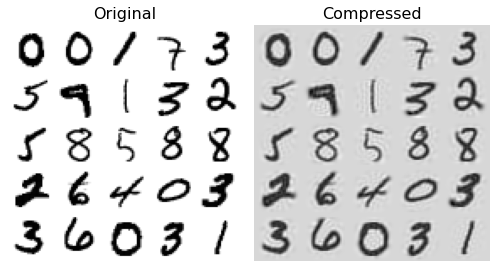

In [51]:
plt.figure(figsize=(7, 4))

# 왼편 원본 손글씨 데이터
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)

# 오른편 재구성된 손글씨 데이터
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

아래 코드는 이어서 설명하는 점진적 PCA 기법의 결과와 비교하기 위해 앞서 설명한 PCA 기법으로 압축된 손글씨 이미지 데이터를 `X_reduced_pca` 로 기억해둔다.

In [52]:
X_reduced_pca = X_reduced

## 랜덤 PCA
`svd_solver='randomized'` 옵션을 사용하면 특잇값 분해 알고리즘에 무작위성을 가하여 차원 $d$만큼의 주성분을 근사적으로 계산한다.

In [53]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

각 알고리즘의 시간 복잡도를 비교하면 다음과 같다.

- 기존의 특잇값 분해 알고리즘의 시간 복잡도: $O(m\times n^2)+O(n^3)$
- 랜덤 특잇값 분해 알고리즘의 시간 복잡도: $O(m \times d^2) + O(d^3)$

따라서 $d$가 $n$보다 많이 작으면 랜덤 PCA가 훨씨 빠르게 작동한다. 이어서 설명하는 점진적 PCA 알고리즘을 소개한 후에 세 알고리즘의 실행속도를 직접 비교할 것이다.

## 점진적 PCA
주성분 분석 알고리즘은 훈련 세트 전체를 이용한다. 따라서 매우 큰 훈련 세트에 대해서는 메모리와 시간과 관련된 문제가 발생한다. 이 문제를 해결하기 위해 점진적 PCA(IPCA, Incremental PCA)를 사용할 수 있다.

- 미니 배치 학습처럼 지정된 크기의 훈련 데이터(미니 배치)를 차례대로 적재하면서 주성분을 분석함.
- 온라인 PCA를 구현할 때 유용함.

아래 코드는 훈련 세트를 쪼개서 미니 배치 단위로 `IncrementalPCA` 모델을 훈련하는 방법을 보여준다.

- 훈련 세트를 지정된 미니 배치 크기로 쪼갠 후 `for` 반복문 실행.
- 반복 과정에서 `fit()`가 아닌 `partial_fit()`를 반드시 사용해야 함.

In [54]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100                             # 배치 개수. 미니 배치 크기 = 52,500/100 = 525.
inc_pca = IncrementalPCA(n_components=154)  # 154개의 주성분을 사용하는 모델 지정

for X_batch in np.array_split(X_train, n_batches):
    print(".", end="")                      # 학습 진도를 보여주는 용도
    inc_pca.partial_fit(X_batch)            # partial_fit() 메서드 사용

X_reduced = inc_pca.transform(X_train)      # 154 차원으로 사영하기

....................................................................................................

**주의사항**: 위 방식은 아래와 같이 `batch_size` 옵션인자와 `fit()` 메서드를 활용하는 방식과 동일하다.

In [55]:
batch_size = len(X_train)//n_batches

inc_pca_fit = IncrementalPCA(n_components=154, batch_size=batch_size)
X_reduced_fit = inc_pca_fit.fit_transform(X_train)

실제로 사영 결과가 동일하다.

In [56]:
np.allclose(X_reduced, X_reduced_fit)

True

#### 재구성 하기
점진적 PCA를 이용해서 사영된 데이터를 재구성한 결과를 비교해서 역시 숫자 인식에는 전혀 문제가 없어 보인다.

In [57]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

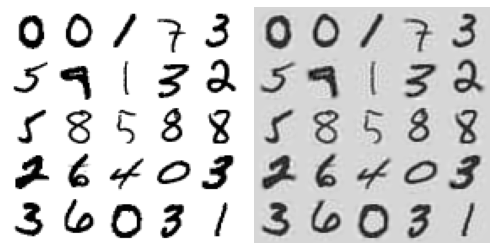

In [58]:
plt.figure(figsize=(7, 4))

# 왼편: 원본 데이터
plt.subplot(121)
plot_digits(X_train[::2100])

# 오른편: 점진적 PCA로 사영되었다가 재구성된 데이터
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])

plt.tight_layout()

아래 코드는 앞서 설명한 다른 PCA의 결과와 비교하기 위해 점진적 PCA로 사영된 데이터를 기억해 둔다.

In [59]:
X_reduced_inc_pca = X_reduced

#### PCA와 IPCA 비교
특잇값 분해 알고리즘에 필요한 훈련 세트의 평균값은 동일한 값이 계산되었다.

In [60]:
np.allclose(pca.mean_, inc_pca.mean_)

True

하지만 사영 결과는 다르다. 점진적 PCA 기법의 사영 결과는 상당히 좋기는 하지만 완벽하진 않다.

In [61]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

### `memmap()` 함수 사용하기
넘파이의 `memmap()` 함수를 이용하여 매우 큰 데이터셋을 마치 실제로 메모리에 적재한 것인양 처리하는 `memmap` 객체를 생성해서 활용할 수 있다. 처리 과정이 좀 복잡하기는 하지만 몇 개의 지정된 단계를 거치면 된다.

참고: memmap은 memory-map의 줄임말이다. 실제로는 컴퓨터 저장장치에 저장된 파일을 마치 메모리상의 어레이로 불러온 효과를 보이는 어레이 객체를 가리킨다.

1단계: `memmap` 객체를 생성한 후에 훈련 세트와 연결시킨다.

In [62]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n)) # memmap 객체 생성
X_mm[:] = X_train   # 훈련 세트와 연결시킴

`X_mm`의 자료형은 `memmap`이다.

In [63]:
type(X_mm)

numpy.memmap

크기는 훈련 세트의 크기와 동일하다.

In [64]:
X_mm.shape

(52500, 784)

`memmap` 객체를 삭제하는 방식으로 더 이상 어레이 조작이 불가능하도록 컴퓨터에 `data` 확장자를 가진 바이너리 파일로 저장시킨다. 그러면 현재 파이썬이 실행되는 디렉토리에 "my_mnist.data"라는 파일이 생성된다.

In [65]:
del X_mm

앞서와 동일한 방식으로 저장된 바이너리 파일을 불러온다. 어레이의 모양도 다시 동일하게 지정해야 함에 주의하라.

In [66]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

배치 크기를 지정한 후에 IPCA 모델을 훈련시킨다. 여기서는 `fit()` 메서드를 그대로 사용해도 된다.

In [67]:
batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

### 시간 복잡도 비교
앞서 소개된 세 종류의 PCA 알고리즘의 시간 복잡도를 예제를 통해 비교해보자. 그러면 랜덤 PCA, 일반 PCA, 점진적 PCA 순으로 점점 느려진다. 방식은 2차원, 10차원, 154차원으로 사영하는 기준을 따른다.

In [68]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    
    # 일반 PCA
    regular_pca = PCA(n_components=n_components, svd_solver="full") 
    # 점진적 PCA
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    # 랜덤 PCA
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for name, pca in (("PCA", regular_pca), ("Inc PCA", inc_pca), ("Rnd PCA", rnd_pca)):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(name, t2 - t1))

n_components = 2
    PCA: 14.6 seconds
    Inc PCA: 28.3 seconds
    Rnd PCA: 4.6 seconds
n_components = 10
    PCA: 11.2 seconds
    Inc PCA: 23.3 seconds
    Rnd PCA: 4.5 seconds
n_components = 154
    PCA: 11.1 seconds
    Inc PCA: 58.7 seconds
    Rnd PCA: 12.0 seconds


아래 코드는 일반 PCA와 랜덤 PCA를 직접 비교한다. 비교는 차원은 고정시킨 채 훈련 세트의 크기를 증가시키는 방식이며 일반 PCA 방식이 훨씬 빠름을 보여준다.

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

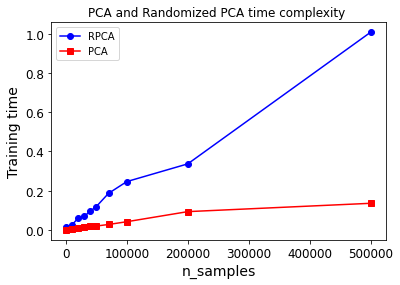

In [69]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    
    rpca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    rpca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

아래 코드는 일반 PCA와 랜덤 PCA를 다른 방식으로 비교한다. 이번에는 훈련 세트의 크기와 사영 공간의 차원은 고정시킨 채 훈련 데이터의 차원을 늘린다. 즉, 원 데이터의 차원과 사영 공간의 차원 사이의 차이를 점점 키우는 방식을 이용한다. 그러면 두 차원의 차이가 커질 수록 랜덤 PCA 방식이 훨씬 빠름을 잘 보여준다.



Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

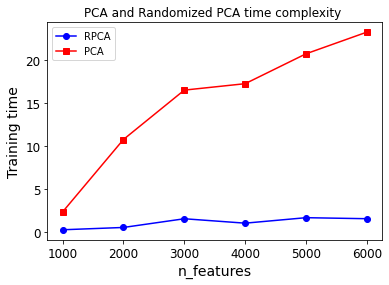

In [70]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    
    rpca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    rpca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

## 커널 PCA
기본적으로 선형 분류 또는 회귀만을 지원하는 서포트 벡터 머신(SVM)에 커널 기법을 적용하여 비선형 분류와 회귀를 지원하도록 하는 아이디어를 PCA 기법에 적용한다.

커널 기법의 기본 아이디어는 데이터를 고차원으로 보낼 때 갑자기 선형 분류/회귀가 가능해질 수 있다는 것이다. 그런데 동일한 이유로 고차원으로 보내진 데이터셋의 주성분 찾기가 보다 쉬워질 수 있다. 실제로 롤케이크 데이터의 경우 선형 주성분 찾는 일이 매우 힘들어 보이지만 커널 기법을 이용해서 고차원으로 보내질 경우 선형 주성분 찾는 일이 가능해짐을 아래 가운데에 있는 그래프를 통해 확인할 수 있다.

### 다양한 커널 기법 적용 예제
아래 코드는 세 종류의 커널을 활용한 결과를 그래프로 보여준다.

- 왼쪽: 선형 커널. 일반 PCA와 동일한 효과를 냄.
- 가운데: RBF 커널.
- 오른쪽: 시그모이드 커널

In [71]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [72]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

Saving figure kernel_pca_plot


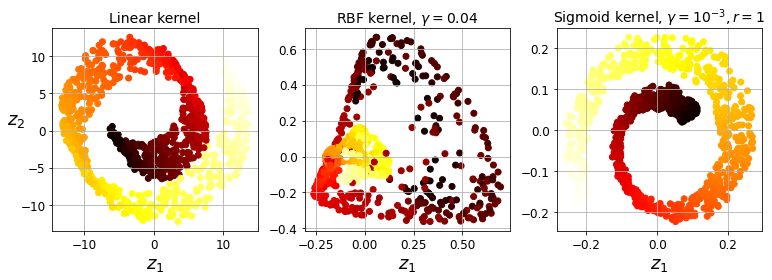

In [73]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

아래 코드는 앞서 rbf 커널 기법으로 2차원으로 사영된 데이터셋을 다시 3차원으로 복원한 결과를 보여준다.

Saving figure preimage_plot


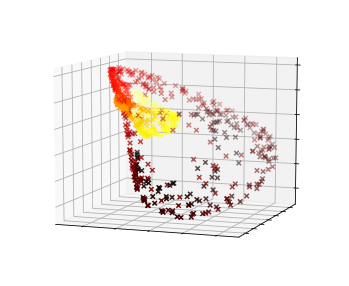

In [74]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

save_fig("preimage_plot", tight_layout=False)
plt.show()

### 커널 선택과 하이퍼파라미터 조정
kPCA는 비지도 학습이다. 따라서 어떤 방식, 어떤 커널이 보다 좋은지 평가할 수 있는 기준이 따로 없다. 하지만 차원축소 이후에 지도학습된 결과를 비교하여 최적의 차원축소 기법과 하이퍼파라미터를 찾을 수는 있다.

예를 들어 아래 코드는 그리드 탐색을 이용하여 최적의 커널 기법과 `gamma` 옵션의 조합을 찾아낸다.

In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

그리드 탐색 결과 RBF 커널을 `gamma=0.043`의 조합이 최선임을 알아냈다.

In [76]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


찾아낸 최적의 조합을 이용할 때의 재구성 오차가 거의 0에 가깝게 나온다.

In [77]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)

X_preimage = rbf_pca.inverse_transform(X_reduced)   # 재구성

In [78]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)   # 재구성 오차가 거의 0임

32.78630879576613

### LLE
국소적 선형 임베딩(LLE, locally linear embedding)은 다양체 학습에 의존하는 비선형 차원축소 기법이다. 아래 코드는 롤케이크를 LLE 방식으로 2차원으로 사영한 결과를 보여준다.

In [79]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [80]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

Saving figure lle_unrolling_plot


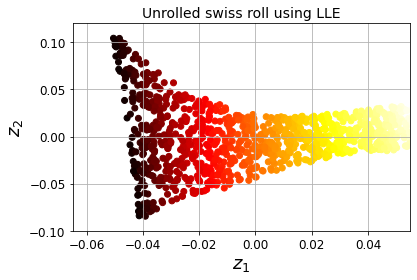

In [81]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)

plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

## 기타 차원축소 기법
아래 코드는 기타 차원축소 기법을 사용하는 방식을 보여준다.

### 사영 기법
- 선형 판별 분석(LDA)

In [82]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

### 다양체 학습 기법
- 다차원 스케일링(MDS, multidimensional scaling)

In [83]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

- Isomap

In [84]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

- t-SNE(t-distributed stochastic neighbor embedding)

In [85]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


아래 코드는 롤케이크를 MDS, Isomap, t-SNE 방식으로 2차원으로 차원축소한 결과를 보여준다.

Saving figure other_dim_reduction_plot


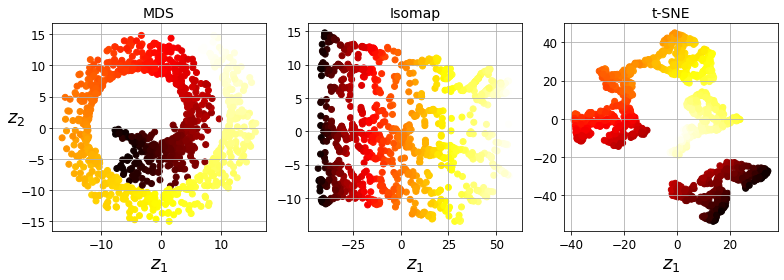

In [86]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()